In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define drift and diffusion functions
def mu(x, coupling_constants):
    return -0.5 * x + coupling_constants[0] * x

def sigma(x, coupling_constants):
    return 0.1 * (1 + coupling_constants[1])  # Ensure non-negative diffusion

class Time_Series_Generator:
    def __init__(self, num_nodes, coupling_constants, correlation_matrix):
        self.num_nodes = num_nodes
        self.coupling_constants = coupling_constants
        self.correlation_matrix = correlation_matrix
        self.correlation_decomposition = np.linalg.cholesky(correlation_matrix)  # Cholesky decomposition
        self.time_series = None

    def simulate_sde(self, mu, sigma, dt, num_steps):
        self.time_series = np.full((self.num_nodes, num_steps), 10.0)  # Initialize time series
        
        for t in range(1, num_steps):
            dW = np.random.normal(size=self.num_nodes) * np.sqrt(dt)
            correlated_noise = np.dot(self.correlation_decomposition, dW)
            
            drift = mu(self.time_series[:, t-1], self.coupling_constants) * dt
            diffusion = sigma(self.time_series[:, t-1], self.coupling_constants) * correlated_noise
            
            # Avoid overflow by capping drift and diffusion at smaller values
            drift = np.clip(drift, -5, 5)
            diffusion = np.clip(diffusion, -5, 5)
            
            # Additive update to avoid exponential growth and overflow
            self.time_series[:, t] = self.time_series[:, t-1] + drift + diffusion
            
            # Ensure the time series doesn't grow too large or become NaN
            self.time_series[:, t] = np.clip(self.time_series[:, t], -100, 100)

            # Check for any NaN values in time series (result from overflow)
            if np.any(np.isnan(self.time_series[:, t])):
                raise ValueError("NaN values encountered during simulation. Adjust the clipping or step size.")

    def get_correlation_matrix(self):
        if self.time_series is None:
            raise ValueError("Time series has not been simulated yet.")
        return np.corrcoef(self.time_series)

# Define parameter ranges for grid search
def create_grid(start, end, step):
    return np.arange(start, end + step, step)

def grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges):
    best_error = float('inf')
    best_params = None
    
    # Create a grid of parameter combinations
    grids = [create_grid(start, end, step) for start, end, step in parameter_ranges]
    
    for coupling1 in grids[0]:
        for coupling2 in grids[1]:
            # Define coupling constants for the current grid point
            coupling_constants = np.array([coupling1, coupling2])
            
            # Create and simulate generator
            generator = Time_Series_Generator(num_nodes, coupling_constants, target_correlation_matrix)
            generator.simulate_sde(mu, sigma, dt, num_steps)
            simulated_correlation_matrix = generator.get_correlation_matrix()
            
            # Compute the error
            error = np.sum((simulated_correlation_matrix - target_correlation_matrix) ** 2)
            
            # Update the best parameters if the current error is lower
            if error < best_error:
                best_error = error
                best_params = coupling_constants
    
    return best_params, best_error

In [2]:
# Example usage
num_nodes = 5

# High correlation
target_correlation_matrix = np.array([
    [1.0, 0.9, 0.90, 0.8, 0.75],
    [0.9, 1.0, 0.88, 0.82, 0.78],
    [0.85, 0.88, 1.0, 0.86, 0.8],
    [0.8, 0.82, 0.86, 1.0, 0.85],
    [0.75, 0.78, 0.8, 0.85, 1.0]
])

dt = 0.01
num_steps = 1000

# Define parameter ranges for coupling constants
parameter_ranges = [(0.0, 1.0, 0.1), (0.0, 1.0, 0.1)]  # (start, end, step) for each constant

# Perform grid search
best_params, best_error = grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges)

# Simulate with best parameters
t_series = Time_Series_Generator(num_nodes, best_params, target_correlation_matrix)
t_series.simulate_sde(mu, sigma, dt, num_steps)

In [3]:
print("Best coupling constants:", best_params)
print("Best error:", best_error)

Best coupling constants: [0.5 0. ]
Best error: 0.11233139055369122


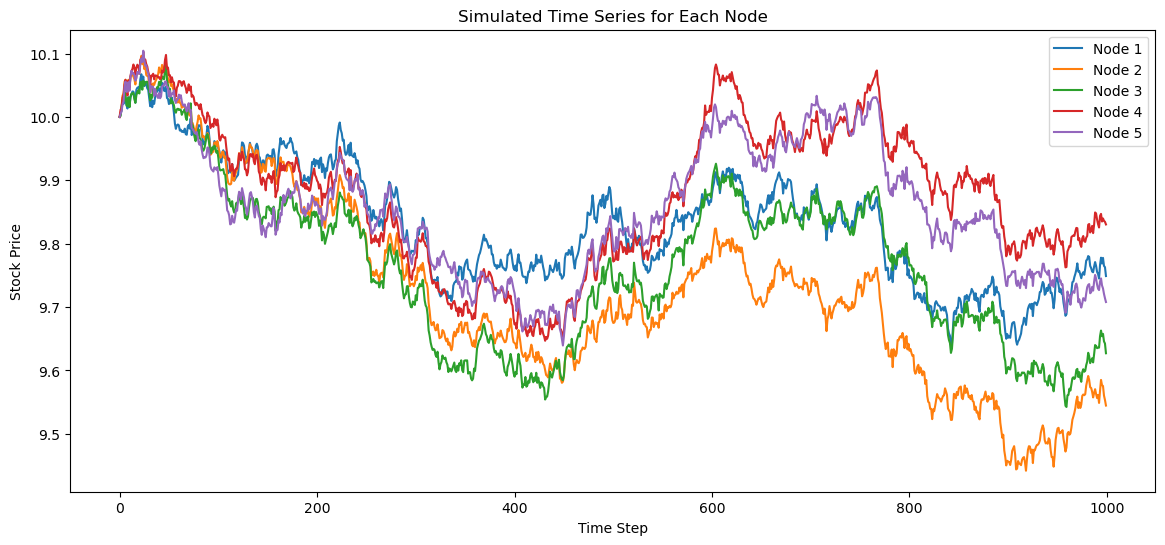

In [4]:
# Plotting the time series
plt.figure(figsize=(14, 6))
for i in range(num_nodes):
    plt.plot(t_series.time_series[i, :], label=f'Node {i+1}')
plt.title('Simulated Time Series for Each Node')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

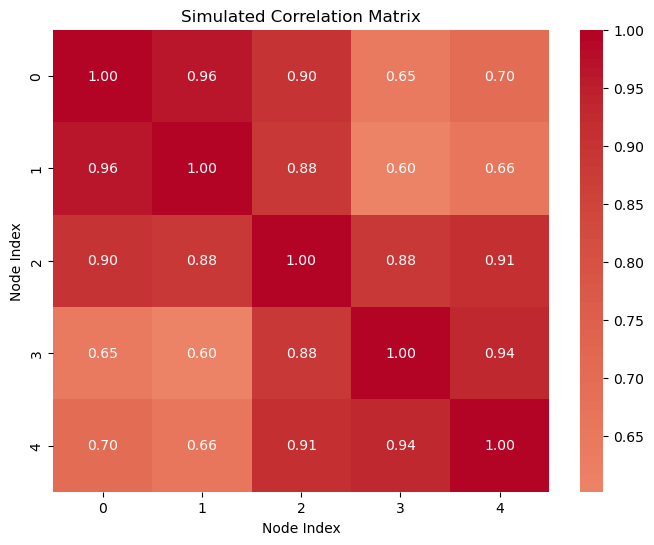

In [5]:
# Plotting the correlation matrix
simulated_correlation_matrix = t_series.get_correlation_matrix()
plt.figure(figsize=(8, 6))
sns.heatmap(simulated_correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Simulated Correlation Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()

In [8]:
#Time series of a single node rescaled to match a stock-price

import pandas as pd

# Convert one of the nodes' time series to stock prices
node_index = 2  # Choose the node index to use
price_series = t_series.time_series[node_index]

# Normalize the stock prices to a realistic range
min_price, max_price = 50, 150
normalized_prices = np.interp(price_series, (price_series.min(), price_series.max()), (min_price, max_price))

# Create a date range
dates = pd.date_range(start='2023-01-01', periods=num_steps, freq='D')
df = pd.DataFrame(data={'Date': dates, 'StockPrice': normalized_prices})

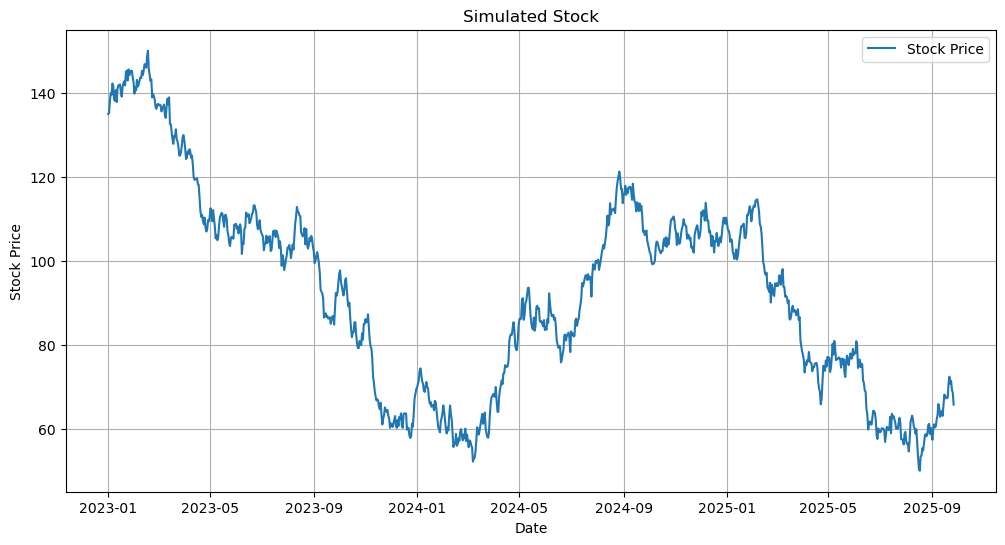

In [9]:
# Plot the stock prices
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['StockPrice'], label='Stock Price')
plt.title('Simulated Stock')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
#This function has been adapted from a course on Datacamp

import numpy as np
from scipy.stats import norm


# Auxiliary function for d_one risk-adjusted probability
def d11(S, X, T, r, sigma):
    """This is an auxiliary function and is not intended to be called externally."""
    return (np.log(S/X) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))

# Auxiliary function for d_two risk-adjusted probability    
def d21(d1, T, sigma):
    """This is an auxiliary function and is not intended to be called externally."""
    return d1 - sigma * np.sqrt(T)

# Definition of the Black-Scholes delta function    
def bs_delta(S, X, T, r, sigma, option_type):
    """Compute the delta of the Black-Scholes option pricing formula.
    
    Arguments:
    S           -- the current spot price of the underlying stock
    X           -- the option strike price
    T           -- the time until maturity (in fractions of a year)
    r           -- the risk-free interest rate 
    sigma       -- the returns volatility of the underlying stock
    option_type -- the option type, either 'call' or 'put'
    
    Returns: a numpy.float_ representing the delta value
    Exceptions raised: ValueError if option_type is not 'call' or 'put'
        """
    if option_type == 'call':
        return norm.cdf(d11(S, X, T, r, sigma))
    elif option_type == 'put':
        return norm.cdf(-d11(S, X, T, r, sigma))
    else:
        # Raise an error if the option_type is neither a call nor a put
        raise ValueError("Option type is either 'call' or 'put'.")

# Definition of the Black-Scholes European option pricing formula    
def black_scholes(S, X, T, r, sigma, option_type):
    """Price a European option using the Black-Scholes option pricing formula.
    
    Arguments:
    S           -- the current spot price of the underlying stock
    X           -- the option strike price
    T           -- the time until maturity (in fractions of a year)
    r           -- the risk-free interest rate 
    sigma       -- the returns volatility of the underlying stock
    option_type -- the option type, either 'call' or 'put'
    
    Returns: a numpy.float_ representing the option value
    Exceptions raised: ValueError if option_type is not 'call' or 'put'
    """
    d_one = d11(S, X, T, r, sigma)
    d_two = d21(d_one, T, sigma)
    if option_type == 'call':
        return S * norm.cdf(d_one) - np.exp(-r * T) * X * norm.cdf(d_two)
    elif option_type == 'put':
        return -(S * norm.cdf(-d_one) - np.exp(-r * T) * X * norm.cdf(-d_two))
    else:
    # Raise an error if the option_type is neither a call nor a put
        raise ValueError("Option type is either 'call' or 'put'.")

In [11]:
import numpy as np

# Compute daily returns
returns = df['StockPrice'].pct_change()

In [12]:
#The strike price K, i.e. the price an investor has the right (but not the obligation) to buy is 80.
#The risk-free interest rate r is 2% and the market spot price S is 90.


# Compute the volatility as the annualized standard deviation of returns
sigma = np.sqrt(252) * returns.std()

# Compute the Black-Scholes option price for this volatility
value_s = black_scholes(S = 90, X = 80, T = 0.5, r = 0.02, 
                        sigma = sigma, option_type = "call")

# Compute the Black-Scholes option price for twice the volatility
value_2s = black_scholes(S = 90, X = 80, T = 0.5, r = 0.02, 
                         sigma = 2 * sigma, option_type = "call")

# Display and compare both values
print("Option value for sigma: ", value_s, "\n", 
      "Option value for 2 * sigma: ", value_2s)

Option value for sigma:  14.852570016861975 
 Option value for 2 * sigma:  22.565269653835465
